# Fluxo de Trabalho de Machine Learning

Neste notebook veremos com mais detalhes o fluxo de trabalho de Machine Learning com a biblioteca **Scikit-Learn**.

Abordaremos os seguintes tópicos:

1. Preparando os Dados
2. Escolhendo o melhor Modelo/Estimador/Algoritmo para os nossos problemas
3. Ajustar o Modelo e usá-lo para fazer previsões em nossos dados
4. Avaliar o desempenho do Modelo
5. Aperfeiçoar o Modelo
6. Salvar e carregar o Modelo treinado

Antes de tudo, vamos importar as bibliotecas necessárias para trabalharmos adequadamente.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 5. Melhorando o Modelo

Como podemos melhorar o nosso modelo?

Através de uma perspectiva de dados, podemos nos questionar:

- Podemos coletar mais dados? (Geralmente quanto mais dados, melhor)
- Podemos melhorar os nossos dados? (Possivelmente mais features, mais informações úteis)

Através de uma perspectiva de modelo, podemos nos questionar:

- Há um modelo melhor que podemos utilizar?
- Podemos melhorar o modelo atual que estamos usando (alterar os hiperparâmetros do algoritmo)

Lembrando que:

- **Parâmetros** = Modelo encontra padrões nos dados
- **Hiperparâmetros** = Configurações em um modelo que podemos ajustar para (potencialmente) melhorar a sua habilidade de encontrar padrões.

Para encontrar os hiperparâmetros que podemos ajustar para um determinado modelo, podemos usar a função **get_params()** após instanciarmos o modelo.

Por exemplo:

In [138]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Veremos então três maneiras de ajustar os hiperparâmetros:

1. Manualmente
2. Aleatoriamente com **RandomSearchCV**
3. Exaustivamente com **GridSearchCV**

Começaremos tunando os hiperparâmetros manualmente.

Faremos três conjuntos de dados: **treinamento**, **validação** e **teste**.

Para o Algoritmo **RandomForestClassifier**, iremos ajustar os seguintes hiperparâmetros:

- **max_depth**
- **max_features**
- **min_samples_leaf**
- **min_samples_split**
- **n_estimators**

Primeiramente vamos definir uma função que calcula diferentes métricas para um modelo de classificação.

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_preds(y_true, y_preds):
    """
    Executa a comparação de avaliação em y_true labels vs y_preds labels em uma classificação
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    metric_dict = {
        "accuracy": round(accuracy,2),
        "precision": round(precision, 2),
        "recall": round(recall, 2),
        "f1": round(f1, 2)
    }
    
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

Agora vamos trabalhar na divisão dos nossos dados, dessa vez trabalharemos com um conjunto de validação, uma boa prática para evitar vazamento de dados do conjunto de testes, assim evitando **Overfitting**.

In [140]:
from sklearn.ensemble import RandomForestClassifier

# Carregamos os nossos dados
heart_disease = pd.read_csv('dados/heart-disease.csv')

# Vamos embaralhar os dados
heart_disease_shuffled = heart_disease.sample(frac=1)

# Dividimos os dados em X e y
X = heart_disease_shuffled.drop('target',axis=1)
y = heart_disease_shuffled['target']

# Separamos os dados em conjuntos de treinamento, validação e teste
train_split = round(0.7 * len(heart_disease_shuffled)) # 70% dos dados
valid_split = round(train_split + 0.15 * len(heart_disease_shuffled)) # 15% dos dados

X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

print(len(X_train) + len(X_valid) + len(X_test))

303


Instanciamos o nosso algoritmo e fazemos previsões no **modelo base** usando o conjunto de validação.

In [141]:
clf = RandomForestClassifier().fit(X_train, y_train)

y_preds = clf.predict(X_valid)

Avaliamos o nosso algoritmo classificador no conjunto de validação.

In [142]:
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Acc: 71.11%
Precision: 0.80
Recall: 0.71
F1 score: 0.75


{'accuracy': 0.71, 'precision': 0.8, 'recall': 0.71, 'f1': 0.75}

Criaremos um segundo classificador com diferentes hiperparâmetros e faremos previsões com ele.

In [143]:
clf_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

y_preds_2 = clf_2.predict(X_valid)

Avaliamos o nosso segundo algoritmo no conjunto de validação.

In [144]:
clf_2_metrics = evaluate_preds(y_valid, y_preds_2)
clf_2_metrics

Acc: 68.89%
Precision: 0.79
Recall: 0.68
F1 score: 0.73


{'accuracy': 0.69, 'precision': 0.79, 'recall': 0.68, 'f1': 0.73}

Alterar os hiperparâmetros manualmente pode ser uma tarefa repetitiva e inviável para muitos casos, por este motivo existem técnicas para 'tunar' os hiperparâmetros de forma automática.

Começaremos vendo como podemos fazer esse tuning usando a técnica **RandomizedSearchCV**.

Definiremos um dicionários com diferentes hiperparâmetros e o valor respectivo que desejamos testar em nosso algoritmo.

In [145]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

Novamente vamos dividir os nosso dados.

In [146]:
X = heart_disease_shuffled.drop('target',axis=1)
y = heart_disease_shuffled['target']

Separamos os dados em conjuntos de **treinamento** e **teste**.

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Instanciamos o modelo classificador.

Dessa vez iremos definir o parâmetro **n_jobs**, que indica o quanto de processamento de nossa máquina será dedicado para as computações desse modelo.

In [148]:
clf = RandomForestClassifier(n_jobs=1)

Agora configuraremos o **RandomizedSearchCV**.

Ele será responsável, essencialmente, por combinar vários modelos diferentes baseados nos hiperparâmetros que definimos.

In [149]:
rs_clf = RandomizedSearchCV(estimator=clf, param_distributions=grid, n_iter=10, cv=5, verbose=2)

Uma vez que nosso modelo está pronto, iremos ajustá-lo essa versão do RandomizedSearchCV em nossos dados.

In [150]:
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10, total=   2.1s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10, total=   3.7s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10, total=   2.6s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10, total=   3.2s
[CV] n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=1000, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=10, total=   2.1s
[CV] n_estimators=200, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=20 
[CV]  n_estimators=200, min_samples_split=6, min_samples_leaf=4, max_features=auto, max_depth=20, total=   0.4s
[CV] n_estimators=200, min_samples_split=6, m

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


Agora que ele está finalizado, podemos acessar o atributo **best_params_** que irá nos dizer quais as combinações que tiveram os melhores resultados.

In [151]:
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None}

Finalmente podemos fazer previsões com estes melhores hiperparâmetros, dessa vez quando chamarmos o método **predict()**, ele por padrão irá selecionar esses hiperparâmetros otimizados.

In [152]:
rs_y_preds = rs_clf.predict(X_test)

E avaliamos as nossas previsões usando a função que definimos anteriormente.

In [153]:
rs_metrics = evaluate_preds(y_test, rs_y_preds)
rs_metrics

Acc: 83.61%
Precision: 0.80
Recall: 0.94
F1 score: 0.87


{'accuracy': 0.84, 'precision': 0.8, 'recall': 0.94, 'f1': 0.87}

Como podemos ver, nosso modelo teve uma pequena melhoria em algumas métricas.

Agora veremos como podemos tunar os nossos hiperparâmetros usando **GridSearchCV**.

In [154]:
grid

{'n_estimators': [10, 100, 200, 500, 1000, 1200],
 'max_depth': [None, 5, 10, 20, 30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 4, 6],
 'min_samples_leaf': [1, 2, 4]}

Nossa **grid** de hiperparâmetros está um pouco grande para o **GridSearchCV**, que essencialmente usa um método de força bruta para tentar diversas combinações de hiperparâmetros.

Portanto, vamos definir uma **grid** menor, uma vez que estamos com poder computacional limitado e desejamos apenas apresentar um exemplo.

In [155]:
grid_2 = {'n_estimators': [100, 200, 500],
'max_depth': [None, 5, 10],
'max_features': ['auto', 'sqrt'],
'min_samples_split': [2, 4],
'min_samples_leaf': [1, 2]}

Agora vamos usar o **GridSearchCV**.

In [156]:
from sklearn.model_selection import GridSearchCV

X = heart_disease_shuffled.drop('target',axis=1)
y = heart_disease_shuffled['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_jobs=1)

gs_clf = GridSearchCV(estimator=clf, param_grid=grid_2, cv=5, verbose=2)

gs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.2s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.6s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total=   0.4s
[CV] max_depth=None, max_features=

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


Vejamos quais são os melhores hiperparâmetros que foram encontrados.

In [157]:
gs_clf.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

Finalmente, avaliamos o nosso algoritmo.

In [158]:
gs_y_preds = gs_clf.predict(X_test)

gs_metrics = evaluate_preds(y_test, gs_y_preds)
gs_metrics

Acc: 83.61%
Precision: 0.81
Recall: 0.91
F1 score: 0.85


{'accuracy': 0.84, 'precision': 0.81, 'recall': 0.91, 'f1': 0.85}

Dessa vez, conseguimos aperfeiçoar o nosso modelo em **precision**, porém tivemos uma queda em outras métricas.

Podemos retornar à etapa 1 e experimentar manualmente novos hiperparâmetros e em seguida testar novos números com **RandomizedSearchCV** e **GridSearchCV**.

Agora vamos comparar as diferentes métricas de nossos modelos com mais precisão através de um gráfico.

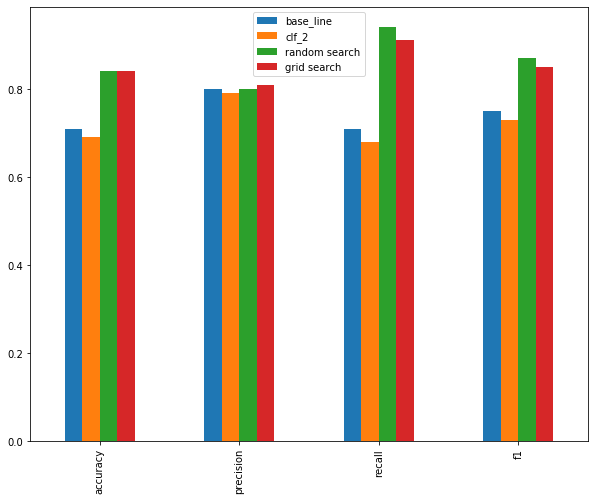

In [160]:
compare_metrics = pd.DataFrame({"base_line": baseline_metrics,
                               "clf_2": clf_2_metrics,
                               "random search": rs_metrics,
                               "grid search": gs_metrics})

compare_metrics.plot.bar(figsize=(10,8));

Com este gráfico, é possível observarmos que o **RandomizedSearchCV** nos traz o melhor modelo.

**Sumarizando**: É importante lembrarmos que este processo de encontrar hiperparâmetros é experimental, portanto é essencial que façamos diferentes experimentos e testes para ver quais combinações podem nos trazer o melhor modelo para o problema que estamos solucionando.

Uma vez que aprendemos como tunar os hiperparâmetros, é então o momento de irmos para a última etapa e descobrir como podemos salvar e carregar nossos modelos para uso futuro.

## 6. Salvando e Carregando Modelos de Machine Learning Treinados

Existem essencialmente duas maneiras de salvar e carregar modelos:

1. Com o módulo **pickle**
2. Com o módulo **joblib**

Primeiramente vamos ver como podemos fazer com **Pickle**.

Devemos importar a biblioteca **pickle**.

E em seguida usamos o método **dump()** para salvar o nosso objeto, que neste caso é o modelo de Machine Learning.

In [161]:
import pickle

pickle.dump(gs_clf, open('modelos/gs_random_forest_model_1.pkl', 'wb'))

E para carregar o modelo salvo, podemos usar a função **load()** do módulo pickle.

In [162]:
loaded_pickle_model = pickle.load(open('modelos/gs_random_forest_model_1.pkl', 'rb'))

E agora podemos fazer previsões com este modelo carregado, exatamente como fizemos antes.

In [163]:
pickle_y_preds = loaded_pickle_model.predict(X_test)
evaluate_preds(y_test, pickle_y_preds)

Acc: 83.61%
Precision: 0.81
Recall: 0.91
F1 score: 0.85


{'accuracy': 0.84, 'precision': 0.81, 'recall': 0.91, 'f1': 0.85}

Outra opção que temos é o módulo **Joblib**.

Vamos importar duas funções do módulo joblib: **dump** e **load**.

In [164]:
from joblib import dump, load

Salvamos o nosso modelo com a função **dump()**.

In [165]:
dump(gs_clf, filename='modelos/gs_random_forest_model_1.joblib')

['modelos/gs_random_forest_model_1.joblib']

E carregamos ele com a função **load()**.

In [166]:
loaded_job_model = load(filename='modelos/gs_random_forest_model_1.joblib')

Novamente, podemos fazer previsões com o modelo carregado.

In [167]:
joblib_y_preds = loaded_job_model.predict(X_test)
evaluate_preds(y_test, joblib_y_preds)

Acc: 83.61%
Precision: 0.81
Recall: 0.91
F1 score: 0.85


{'accuracy': 0.84, 'precision': 0.81, 'recall': 0.91, 'f1': 0.85}

Podemos confirmar pelas métricas que se tratam dos mesmos modelos, descobertos pelo **GridSearchCV**.

De acordo com a documentação de Scikit-Learn, é recomendado usar a biblioteca **joblib** para esta tarefa de persistência de modelos, por questões de eficiência.